<span style="font-size:40px; font-family:'Times new roman'; font-weight:bold">
Import Data 🎒
</span>

In [51]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../src')
from binomial import binomial
from greeks import greeks

In [52]:
nvda = pd.read_csv("../data/cleanedNVDA.csv")
spy = pd.read_csv("../data/cleanedSPY.csv")
expiry = [nvda['expiry'].unique()[0], spy['expiry'].unique()[0]]

<span style="font-size:20px; font-family:'Times new roman';">
Let's use the nearest strike to spot and TTM
</span>

In [126]:
def calculateScenario(data):

    # sample data: row 6 from NVDAcleaned
    row = data.iloc[4]

    S = row['spot']
    K = row['strike']
    T = row['ttm']
    sigma = row['impliedVolatility']
    q = row['dividendYield']
    ot = row['type']

    scenario = {}

    # Original case
    scenario['Base'] = greeks(S, K, T, q, ot, sigma)

    # Spot Price +10%
    scenario['Spot Up 10%'] = greeks(S * 1.10, K, T, q, ot, sigma)

    # Spot Price -10%
    scenario['Spot Down 10%'] = greeks(S * 0.90, K, T, q, ot, sigma)

    # Volatility +10%
    scenario['Vol Up 10%'] = greeks(S, K, T, q, ot, sigma * 1.10)

    # Volatility -10%
    scenario['Vol Down 10%'] = greeks(S, K, T, q, ot, sigma * 0.90)

    # Time Decay: 5 day
    if T - (5/365) > 0:
        scenario['5 Days Less'] = greeks(S, K, T - (5/365), q, ot, sigma)
    else:
        scenario['5 Days Less'] = None
    
    scenario = pd.DataFrame.from_dict({k: v for k, v in scenario.items() if v is not None}, orient='index')
    scenario.index.name = 'Scenario'
    scenario.reset_index(inplace=True)

    return scenario


In [132]:
def plotCheck(data, label):
    
    melted = data.melt(id_vars=['Scenario'],
                       value_vars=['delta', 'gamma', 'theta', 'vega'],
                       var_name='Greek',
                       value_name='Value')

    plt.figure(figsize=(7.5,4.5))
    sns.barplot(data=melted, x='Scenario', y='Value', hue='Greek')
    plt.title(f'{label} - Impact of Scenarios on Greeks')
    plt.xticks(rotation=30)
    plt.ylabel('Greek Value')
    plt.xlabel('Scenario')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Greek')
    plt.show()

<span style="font-size:40px; font-family:'Times new roman'; font-weight:bold;">
NVDA data, with spot spike +- 10%, IV spike +- 10% and Time Decay
</span>

In [124]:
nvda.iloc[4]

type                       call
strike                     95.0
ttm                    0.010959
AveragePrice              4.825
impliedVolatility      1.067143
spot                  94.309998
dividendYield              0.04
expiry               2025-04-11
modelPrice             3.888291
Name: 4, dtype: object

In [129]:
nvdaScenario = calculateScenario(nvda)
nvdaScenario

,Scenario,delta,gamma,theta,vega,modelPrice
0,Base,0.482433,0.000011,-205.438102,3.935480,3.888291
1,Spot Up 10%,0.795106,0.077786,-147.054620,3.245020,10.094551
2,Spot Down 10%,0.168998,0.097985,-106.873709,2.071164,0.815648
3,Vol Up 10%,0.484653,0.000011,-225.901074,3.934173,4.308194
4,Vol Down 10%,0.480216,0.000009,-184.958338,3.936663,3.468255


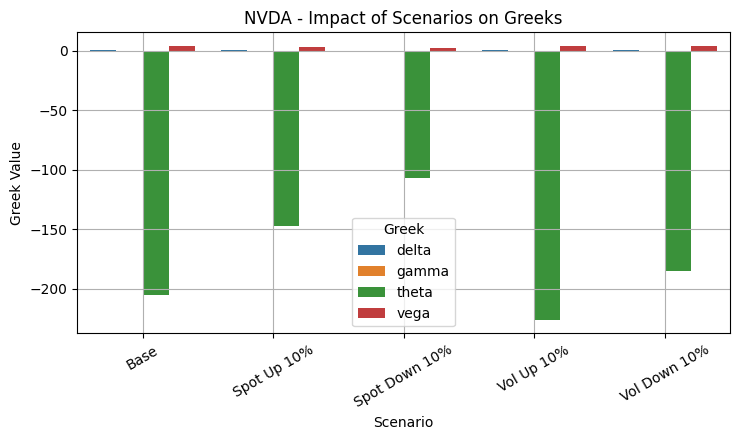

In [133]:
plotCheck(nvdaScenario, "NVDA")

<span style="font-size:40px; font-family:'Times new roman'; font-weight:bold;">
SPY data, with spot spike +- 10%, IV spike +- 10% and Time Decay
</span>

In [80]:
spy.iloc[4]

type                       call
strike                    505.0
ttm                    0.010959
AveragePrice             15.185
impliedVolatility      0.582402
spot                 505.279999
dividendYield              1.28
expiry               2025-04-11
modelPrice             9.860473
Name: 4, dtype: object

In [135]:
spyScenario = calculateScenario(spy)
spyScenario

,Scenario,delta,gamma,theta,vega,modelPrice
0,Base,0.463504,0.023348,-381.892077,20.274553,9.860473
1,Spot Up 10%,1.000000,0.000000,0.000000,0.000000,50.807999
2,Spot Down 10%,0.029375,0.000271,-60.857441,3.162701,0.297927
3,Vol Up 10%,0.468156,0.022906,-436.908754,20.363672,11.044006
4,Vol Down 10%,0.458344,0.023953,-327.635034,20.156888,8.683073


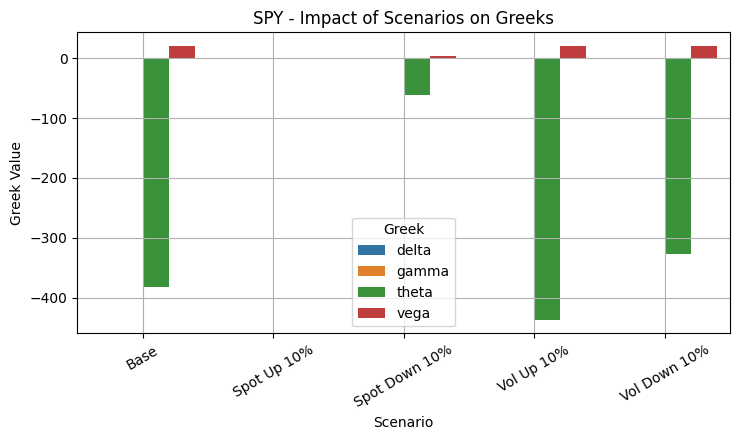

In [136]:
plotCheck(spyScenario, "SPY")